In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import os, h5py
from astropy.io import fits

from msfm.utils import files

In [49]:
conf = files.load_config("../../configs/v9/linear_bias.yaml")
n_side = conf["analysis"]["n_side"]
n_pix = hp.nside2npix(n_side)

def get_rot_x(ang):
    return np.array([[1.0, 0.0,         0.0],
                     [0.0, np.cos(ang), -np.sin(ang)],
                     [0.0, np.sin(ang), np.cos(ang)]]).T # Inverse because of healpy

def get_rot_y(ang):
    return np.array([[np.cos(ang),  0.0, np.sin(ang)],
                     [0.0,          1.0, 0.0],
                     [-np.sin(ang), 0.0, np.cos(ang)]]).T # Inverse because of healpy

def get_rot_z(ang):
    return np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang), np.cos(ang),  0.0],
                     [0.0,         0.0,          1.0]]).T # Inverse because of healpy

In [50]:
# indices
index_dir = "/Users/arne/data/DESY3/public/DESY3_indexcat.h5"
with h5py.File(index_dir, "r") as f:
    indices_metacal = f["index/select"][:]
    indices_maglim = f["index/maglim/select"][:]

# redshifts
dnf_dir = "/Users/arne/data/DESY3/public/DESY3_GOLD_2_2.1_DNF.h5"
with h5py.File(dnf_dir, "r") as f:
    gold_z = f["catalog/unsheared/zmean_sof"][:]

# angular positions
gold_dir = "/Users/arne/data/DESY3/public/DESY3_GOLD_2_2.1.h5"
with h5py.File(gold_dir, "r") as f:
    gold_ra = f["catalog/gold/ra"][:]
    gold_dec = f["catalog/gold/dec"][:]

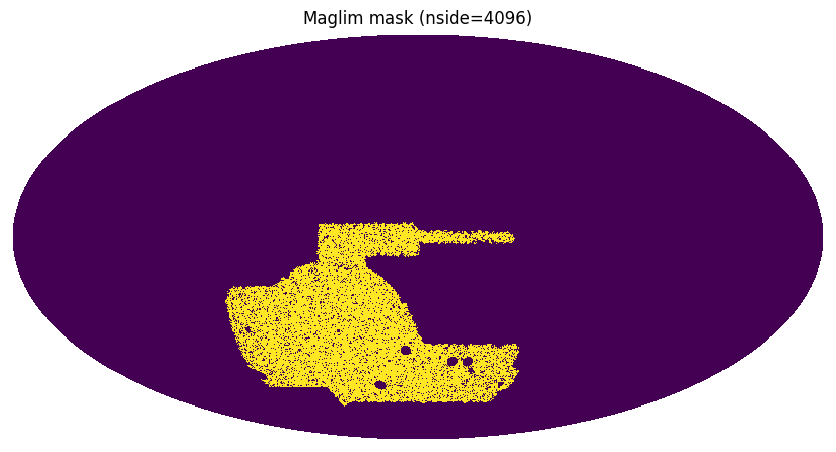

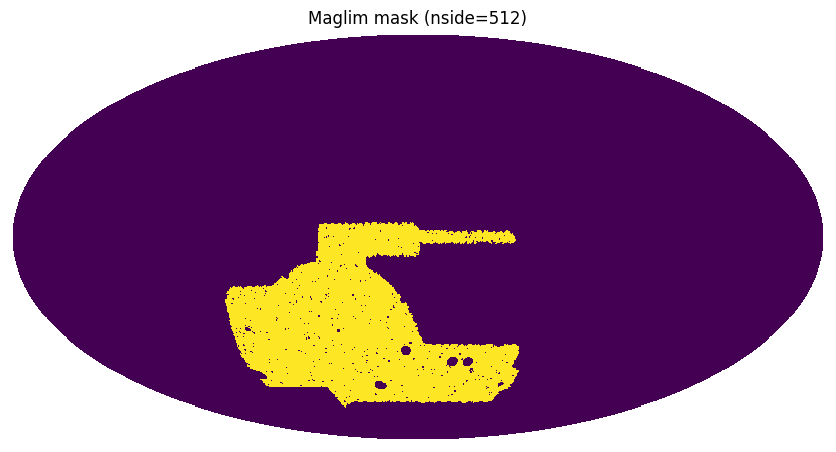

In [51]:
maglim_mask_dir = f"/Users/arne/data/DESY3/masks/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask.fits.gz"
data, header = fits.getdata(maglim_mask_dir, header = True)
maglim_mask_pix = data["HPIX"]

maglim_mask = np.zeros(hp.nside2npix(4096), dtype=bool)
maglim_mask[maglim_mask_pix] = True
hp.mollview(maglim_mask, title="Maglim mask (nside=4096)", cbar=False)

maglim_mask = hp.ud_grade(maglim_mask, nside_out=n_side)
hp.mollview(maglim_mask, title="Maglim mask (nside=512)", cbar=False)

maglim_mask_pix = np.arange(n_pix)[maglim_mask]

metacal [0.0, 0.358] 10371127
metacal [0.358, 0.631] 38731799
metacal [0.631, 0.872] 26401076
metacal [0.872, 2.0] 24695308
maglim [0.2, 0.4] 2236473
2236473
(2236473,)
maglim [0.4, 0.55] 1599500
1599500
(1599500,)
maglim [0.55, 0.7] 1627413
1627413
(1627413,)
maglim [0.7, 0.85] 2175184
2175184
(2175184,)


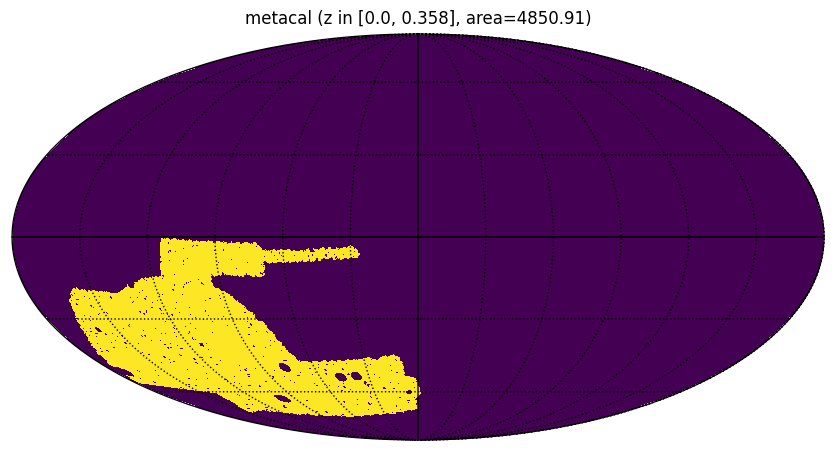

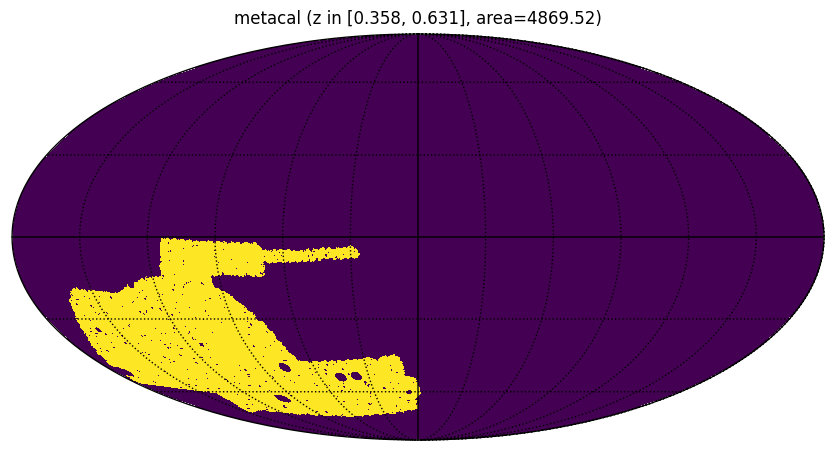

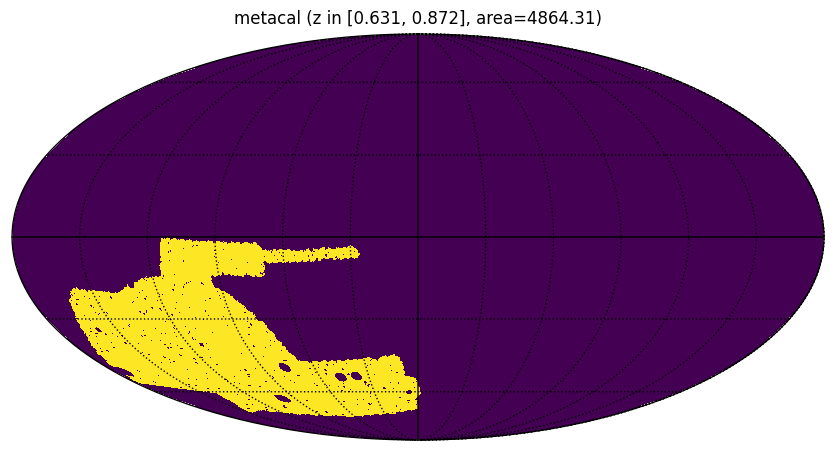

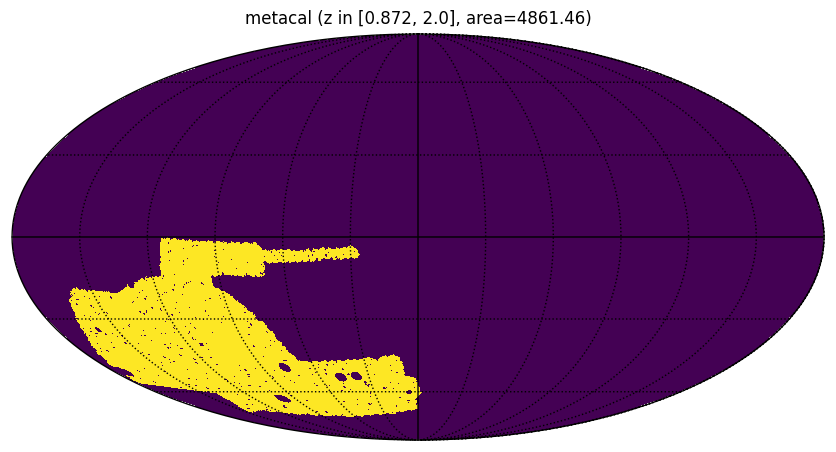

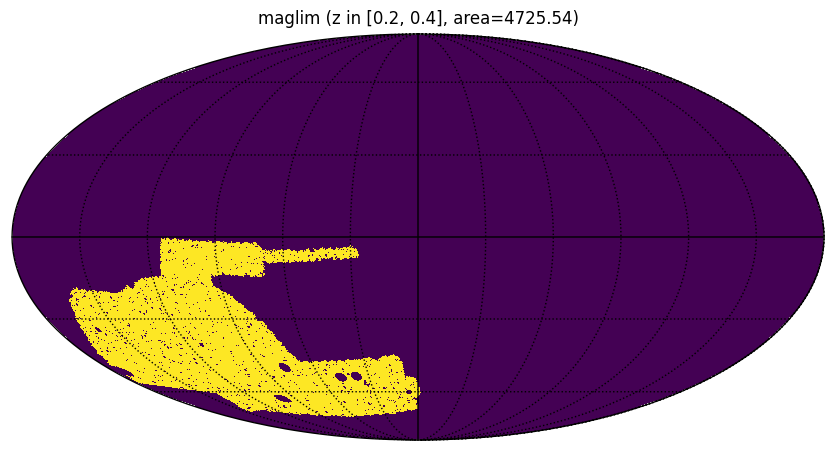

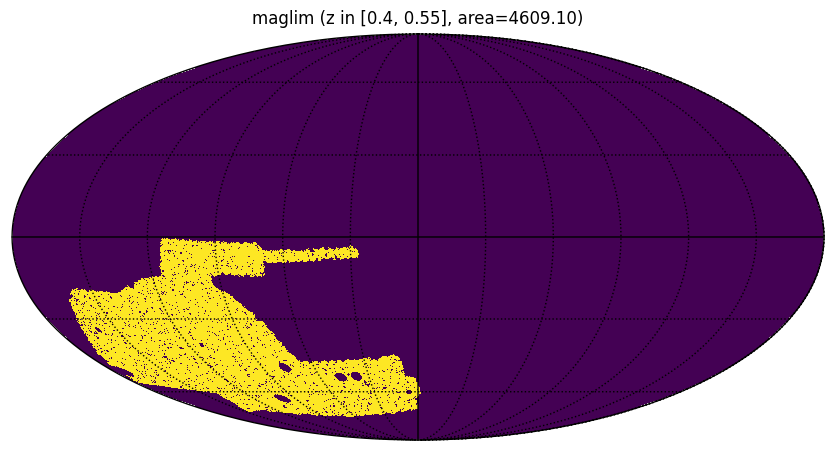

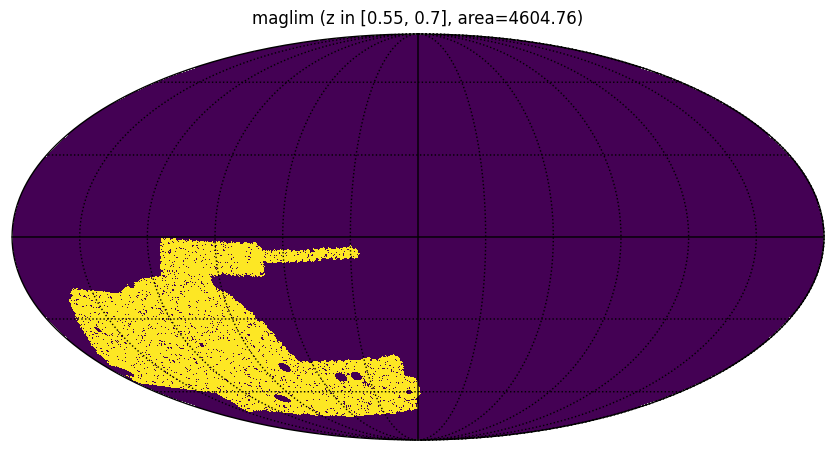

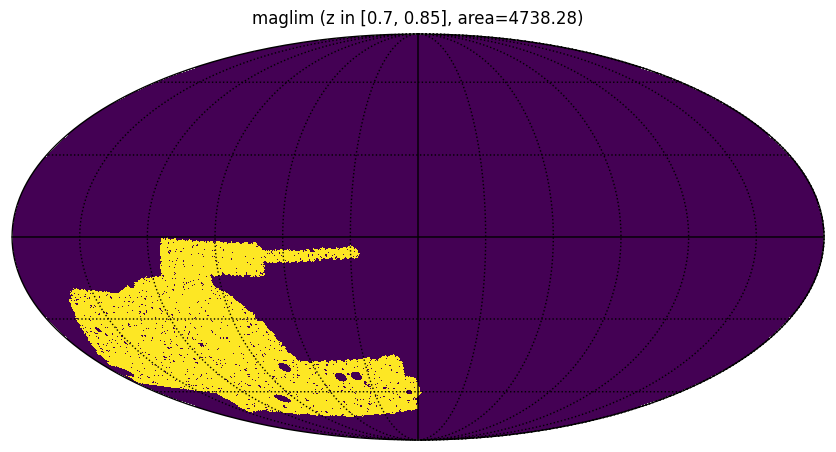

In [52]:
y_rot = get_rot_y(-0.125)
z_rot = get_rot_z(-1.22)

per_bin_pix = []
for sample in ["metacal", "maglim"]:
    if sample == "metacal":
        indices = indices_metacal
    elif sample == "maglim":
        indices = indices_maglim
    else:
        raise ValueError("Unknown sample")
    
    z_lims = conf["survey"][sample]["z_lims"]
    z = gold_z[indices]
    
    for z_lim in z_lims:
        z_mask = (z_lim[0] < z) & (z < z_lim[1])
        z_indices = indices[z_mask]

        print(f"{sample} {z_lim} {len(z_indices)}")

        ra = gold_ra[z_indices]
        dec = gold_dec[z_indices]

        theta = np.pi/2 - np.radians(dec)
        phi = np.radians(ra)
        vec = hp.ang2vec(theta=theta, phi=phi)

        if sample == "maglim":
            pix = hp.vec2pix(n_side, vec[:,0], vec[:,1], vec[:,2])
            pix_mask = np.isin(pix, maglim_mask_pix)
            vec = vec[pix_mask]
            print(np.sum(pix_mask))
            print(pix.shape)

        rot_vec = np.dot(y_rot, vec.T)
        rot_vec = np.dot(z_rot, rot_vec)
        rot_pix = hp.vec2pix(n_side, rot_vec[0], rot_vec[1], rot_vec[2])
        rot_pix = np.unique(rot_pix)
        area = hp.nside2pixarea(n_side, degrees=True) * len(rot_pix)

        mask = np.zeros(n_pix, dtype=bool)
        mask[rot_pix] = True
        hp.mollview(mask, cbar=False, title=f"{sample} (z in {z_lim}, area={area:.2f})")
        hp.graticule()

        per_bin_pix.append(rot_pix)


In [53]:
pix

array([1559805, 1557757, 1557757, ..., 1624844, 1624844, 1622795])

In [54]:
maglim_mask_pix

array([1422518, 1422519, 1424398, ..., 3028277, 3029243, 3029244])

In [55]:
np.isin(pix, maglim_mask_pix)

array([ True,  True,  True, ...,  True,  True,  True])

In [56]:
pix = hp.vec2pix(n_side, vec[:,0], vec[:,1], vec[:,2])
pix.shape

(2175184,)

maglim [0.2, 0.4] 2236473
maglim [0.4, 0.55] 1599500
maglim [0.55, 0.7] 1627413
maglim [0.7, 0.85] 2175184


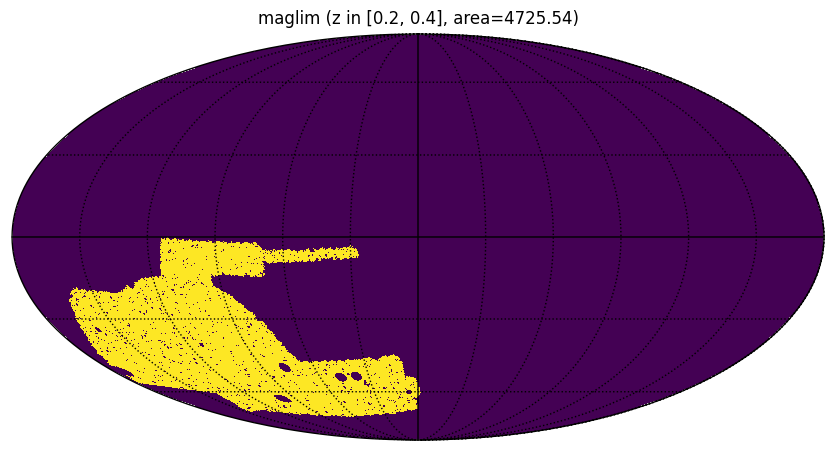

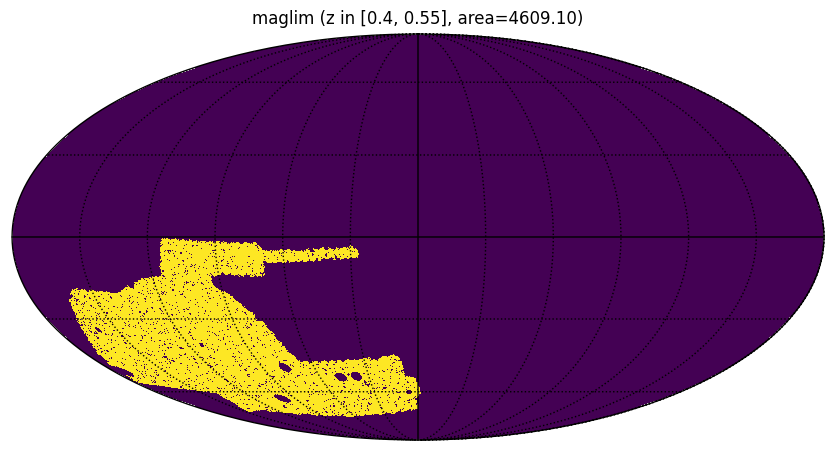

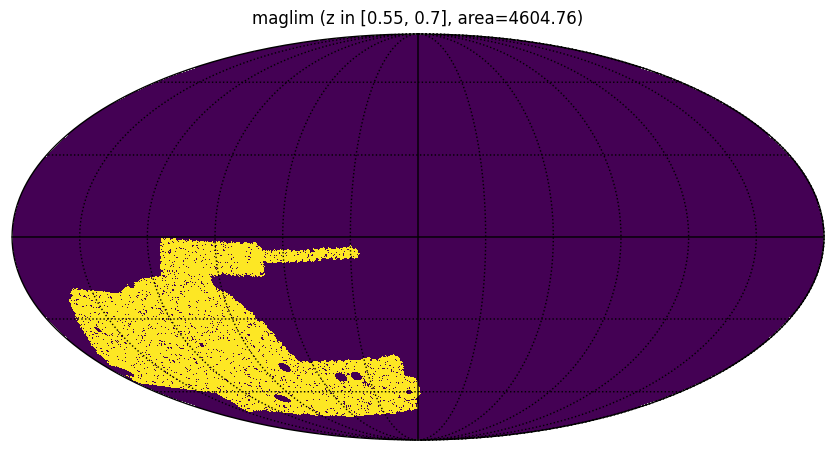

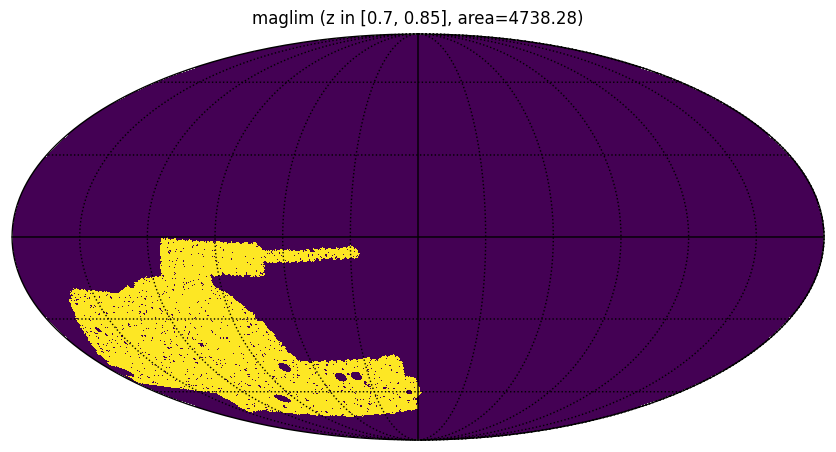

In [57]:
y_rot = get_rot_y(-0.125)
z_rot = get_rot_z(-1.22)

per_bin_pix = []
# for sample in ["metacal", "maglim"]:
for sample in ["maglim"]:
    if sample == "metacal":
        indices = indices_metacal
    elif sample == "maglim":
        indices = indices_maglim
    else:
        raise ValueError("Unknown sample")
    
    z_lims = conf["survey"][sample]["z_lims"]
    z = gold_z[indices]
    
    for z_lim in z_lims:
        z_mask = (z_lim[0] < z) & (z < z_lim[1])
        z_indices = indices[z_mask]

        print(f"{sample} {z_lim} {len(z_indices)}")

        ra = gold_ra[z_indices]
        dec = gold_dec[z_indices]

        theta = np.pi/2 - np.radians(dec)
        phi = np.radians(ra)
        vec = hp.ang2vec(theta=theta, phi=phi)
        
        # if sample =="maglim":
        #     pix = hp.vec2pix(n_side, vec[0], vec[1], vec[2])
        #     pix_mask = np.isin(pix, maglim_mask_pix)
        #     pix = pix[pix_mask]
        
        rot_vec = np.dot(y_rot, vec.T)
        rot_vec = np.dot(z_rot, rot_vec)
        rot_pix = hp.vec2pix(n_side, rot_vec[0], rot_vec[1], rot_vec[2])
        rot_pix = np.unique(rot_pix)
        area = hp.nside2pixarea(n_side, degrees=True) * len(rot_pix)

        mask = np.zeros(n_pix, dtype=bool)
        mask[rot_pix] = True
        hp.mollview(mask, cbar=False, title=f"{sample} (z in {z_lim}, area={area:.2f})")
        hp.graticule()

        per_bin_pix.append(rot_pix)


maglim [0.2, 0.4] 2236473
maglim [0.4, 0.55] 1599500
maglim [0.55, 0.7] 1627413
maglim [0.7, 0.85] 2175184


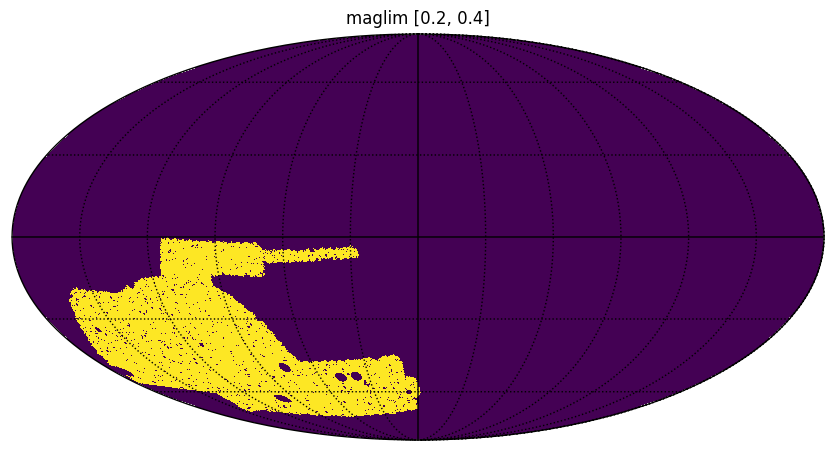

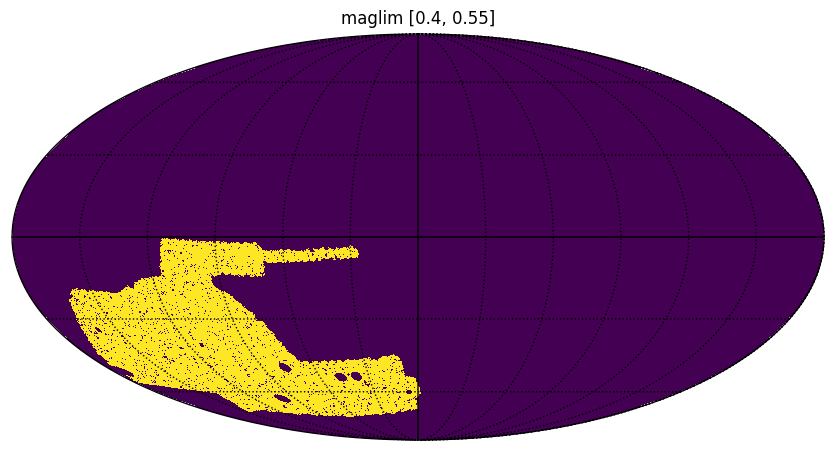

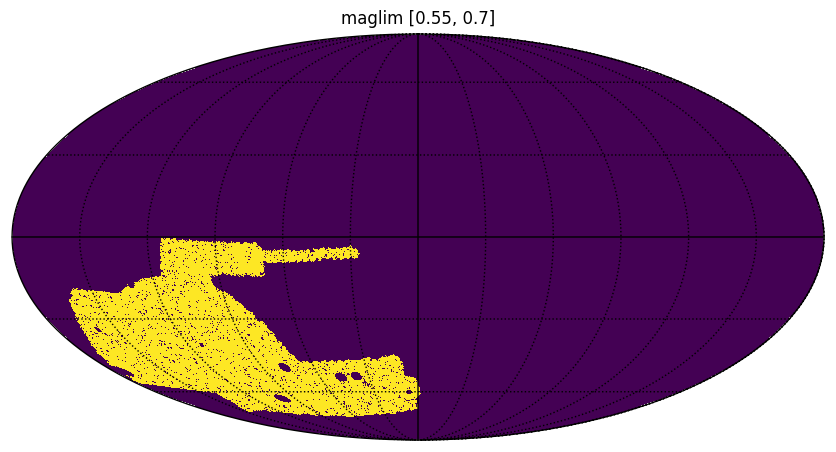

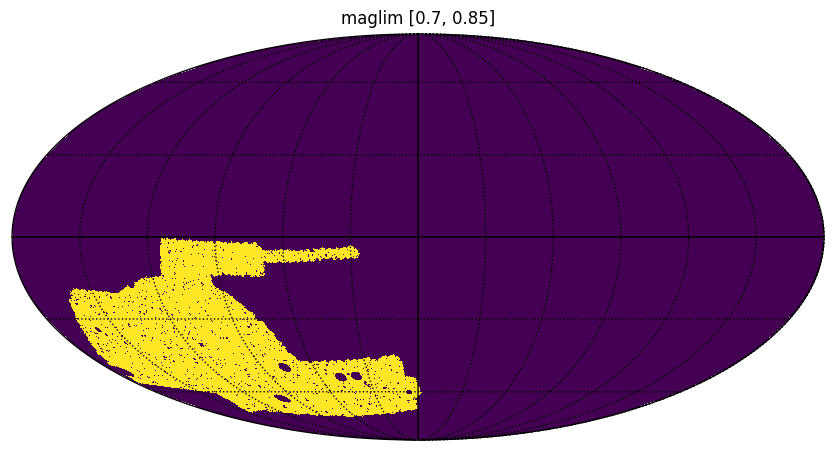

In [58]:
y_rot = get_rot_y(-0.125)
z_rot = get_rot_z(-1.22)

per_bin_pix = []
# for sample in ["metacal", "maglim"]:
for sample in ["maglim"]:
    if sample == "metacal":
        indices = indices_metacal
    elif sample == "maglim":
        indices = indices_maglim
        # mask = 
    else:
        raise ValueError("Unknown sample")
    
    z_lims = conf["survey"][sample]["z_lims"]
    z = gold_z[indices]
    
    for z_lim in z_lims:
        z_mask = (z_lim[0] < z) & (z < z_lim[1])
        z_indices = indices[z_mask]

        # print(f"{sample} {z_lim} {len(z_indices):.2E}")
        print(f"{sample} {z_lim} {len(z_indices)}")

        ra = gold_ra[z_indices]
        dec = gold_dec[z_indices]

        theta = np.pi/2 - np.radians(dec)
        phi = np.radians(ra)
        vec = hp.ang2vec(theta=theta, phi=phi)
        
        rot_vec = np.dot(y_rot, vec.T)
        rot_vec = np.dot(z_rot, rot_vec)
        rot_pix = hp.vec2pix(n_side, rot_vec[0], rot_vec[1], rot_vec[2])

        mask = np.zeros(n_pix, dtype=bool)
        mask[rot_pix] = True
        hp.mollview(mask, cbar=False, title=sample + " " + str(z_lim))
        hp.graticule()

        per_bin_pix.append(rot_pix)


In [59]:
# # Convert each list to a set
# pix_sets = [set(pixels) for pixels in per_bin_pix]

# # Find the intersection of all sets
# pix_intersect = set.intersection(*pix_sets)
# pix_intersect = np.array(list(pix_intersect))

# mask = np.zeros(n_pix, dtype=bool)
# mask[pix_intersect] = True
# hp.mollview(mask, cbar=False, title=sample)
# hp.graticule()